In [1]:
import os
import h5py

import torch
import torchvision
from torchvision.transforms import v2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
!pip install astronn equinox einops
from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion

from pathlib import Path

2024-05-23 23:30:28.588404: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 23:30:28.627940: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 23:30:28.954159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 23:30:30.548614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import fastprogress


from AutoEncoder import Autoencoder

In [4]:
# First time downloading location will be ~/.astroNN/datasets/
images, labels = load_galaxy10()
imagesBarredSpiral = np.array(images[labels == 5]) # class 5 is 'Barred Spiral'


/home/simon/.astroNN/datasets/Galaxy10_DECals.h5 was found!


In [5]:
images_after_resize = []
for img in imagesBarredSpiral:
    imageBS = torch.from_numpy(img).permute(2, 0, 1)

    img64 = v2.Resize(size=64)(imageBS)
    
    images_after_resize.append(img64.permute(1,2,0))
    print(img64.permute(1,2,0).shape)
#images_after_resize

torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 

In [6]:
train_split = 0.6
valid_split = 0.2

test_split = 1 - train_split - valid_split

train_datasetBS, valid_datasetBS, test_datasetBS = torch.utils.data.random_split(
        images_after_resize, [train_split, valid_split, test_split]
)
#train_datasetMW, valid_datasetMW, test_datasetMW = torch.utils.data.random_split(
#        imagesMilky, [train_split, valid_split, test_split]
#)

In [7]:
fig_size = 4

def show_images(images, labels=None, num_columns=5, num_rows=3):
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(fig_size * num_columns, fig_size * num_rows),
                        subplot_kw={'xticks': [], 'yticks': []})

    labels = [None] * num_columns * num_rows if labels is None else labels

    for ax, image, label in zip(axs.flat, images, labels):
        # Use a grayscale colourmap if we have only a single channel
        cmap = 'gray' if image.shape[0] == 1 else None

        # Imshow expects HWC, so backtransform here again
        ax.imshow(np.transpose(image, [1, 2, 0]), cmap=cmap)
        if label:
            ax.set_title(f"{label}")

    plt.tight_layout()
    plt.show()

In [8]:
removenumber = 3*10**2
addnumber = removenumber
epochs = 20
roundsofReplace = (int)(2045/removenumber) + (1 - 2045/removenumber%1)

removenumbertrain = removenumber * train_split
addnumbertrain = addnumber * train_split

removenumbervalid = removenumber * valid_split
addnumbervalid = addnumber * valid_split

In [9]:
def autoencoder_loss(recon_x, x, mu=None, logvar=None):
    mse_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(dim=0)

    if mu is not None and logvar is not None:
        raise NotImplementedError("Looks like you still need to implement the KL divergence loss!")
    else:
        return mse_loss

In [10]:
model = Autoencoder()

In [11]:
learning_rate = 2e-4
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [12]:
def training(data, optimizer, model, loss_fn, master_bar):
    """Run one training epoch.

    Args:
        data: data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float: Mean loss of this epoch
    """
    epoch_loss = []

    dataloader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)
    looparray = fastprogress.progress_bar(dataloader, parent=master_bar)

    for x in looparray:
        optimizer.zero_grad()
        model.train()
        print(type(x))
        # Forward pass
        x_inp = x
        x_hat, mu, logvar = model(x_inp)

        # Compute loss
        loss = loss_fn(x_hat, x, mu, logvar)

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())
        master_bar.child.comment = f"Train Loss: {epoch_loss[-1]:.3f}"

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss)


def validate(data, model, loss_fn, master_bar):
    """Compute loss on validation set.

    Args:
        data: data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        master_bar (fastprogress.master_bar): Will be iterated over to draw
            batches and show validation progress

    Returns:
        float: Mean loss on validation set
    """
    epoch_loss = []

    model.eval()
    with torch.no_grad():
        for x, _ in fastprogress.progress_bar(data, parent=master_bar):
            # make a prediction on test set
            x_inp = x
            x_hat, mu, logvar = model(x_inp)

            # Compute loss
            loss = loss_fn(x_hat, x, mu, logvar)

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())
            master_bar.child.comment = f"Valid. Loss: {epoch_loss[-1]:.3f}"

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss)

In [13]:
def train_model(model, optimizer, loss_function, num_epochs,
                train_data, valid_data):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        num_epochs (int): Max. number of epochs to train
        train_data: training data
        valid_data: validation data

    Returns:
        list, list: Return list of train losses, test losses.
    """
    master_bar = fastprogress.master_bar(range(num_epochs))
    epoch_list, train_losses, valid_losses = [], [], []

    master_bar.names = ["Train", "Valid."]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss = training(train_data, optimizer, model, loss_function, master_bar)
        # Validate the model
        epoch_valid_loss = validate(valid_data, model, loss_function, master_bar)

        # Save loss and acc for plotting
        epoch_list.append(epoch + 1)
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)

        graphs = [[epoch_list, train_losses], [epoch_list, valid_losses]]
        x_bounds = [1, num_epochs]

        master_bar.write(
            f"Epoch {epoch + 1}, "
            f"avg. train loss: {epoch_train_loss:.3f}, "
            f"avg. valid. loss: {epoch_valid_loss:.3f}"
        )
        master_bar.update_graph(graphs, x_bounds)


    return train_losses, valid_losses

In [36]:
def mixdata(dataBS, dataMW, quoteBS, quoteMW):
    data, _ = torch.utils.data.random_split(imagesBarredSpiral, [quoteBS, 1-quoteBS, 0])
    return

In [14]:
train = train_datasetBS
valid = valid_datasetBS
for i in range(3):#roundsofReplace):
  train_model(model, optimizer, autoencoder_loss, epochs, train, valid)
  lowtrain = i*addnumbertrain % len(train_datasetMW)
  hightrain = (i+1)*addnumbertrain % len(train_datasetMW)


<class 'torch.Tensor'>
torch.uint8


RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
.permute(1,2,0)model

Autoencoder(
  (conv_encoder): Sequential(
    (0): Conv2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_lin_down): Linear(in_features=2048, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=128, bias=True)
  (fc_z): Linear(in_features=128, out_features=256, bias=True)
  (fc_lin_up): Linear(in_features=256, out_features=2048, bias=True)
  (conv_decoder): Sequential(
    (0): Conv2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [38]:
for r in train_datasetBS:
    break

In [39]:
model(torch.from_numpy(r).permute(2, 0, 1).unsqueeze(0).float())

TypeError: expected np.ndarray (got Tensor)

In [23]:
torch.from_numpy(r).permute(2, 0, 1).unsqueeze(0).float().shape

torch.Size([1, 3, 256, 256])

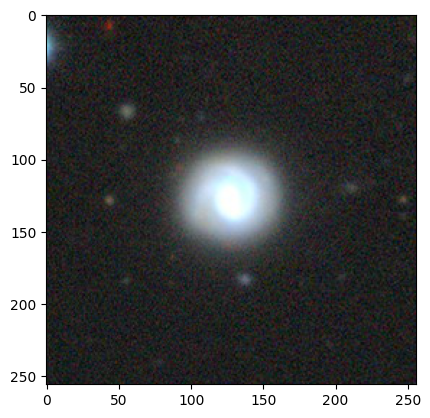

In [24]:
plt.imshow(r)